<a href="https://colab.research.google.com/github/nystuen/UFC_Fight_Prediction/blob/master/FightPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras

# Models
from keras.models import Sequential
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from keras.layers import Dense,Activation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, Activation, Flatten
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score


Using TensorFlow backend.


# **Generate dataset**
- generateDoubleDatasetWithSwappedColors balances dataset
- generateOldDatasetWithoutSwappedColors uses original unbalanced dataset


In [0]:
results = {}
df = pd.read_csv(
    "https://raw.githubusercontent.com/nystuen/UFC_Fight_Prediction/master/preprocessed_data.csv")

scaler = StandardScaler()
df = df.drop(columns = ['B_Stance_Sideways'])
df_num = df.select_dtypes(include=[np.float, np.int])
df['Winner'] = (df['Winner'] != 'Red').astype(int)
df['title_bout'] = (df['title_bout']).astype(int)

def swap_data_frame(swap_data):
    cols = list(swap_data.columns)
    b_cols = [i for i in cols if i[0]=='B']
    for b_c in b_cols:
        r_c = 'R'+b_c[1:]
        b_index = cols.index(b_c)
        r_index = cols.index(r_c)
        cols[b_index], cols[r_index] = cols[r_index], cols[b_index]
    swap_data.columns = cols
    return swap_data

def generateDoubleDatasetWithSwappedColors():
  global df
  swap_data = df.copy()
  swap_data = swap_data_frame(swap_data)
  swap_data['Winner'] = swap_data['Winner'].replace([0,1],[1,0])
  frames = [df,swap_data]
  concat_data = pd.concat(frames)
  concat_correct = concat_data.copy()
  df = concat_correct
  y = concat_correct['Winner']
  print(y.value_counts())
  X = concat_correct.drop(columns = ['Winner'])
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=12)
  print(y_test.value_counts())

  return y, X, x_train, x_test, y_train, y_test

def generateOldDatasetWithoutSwappedColors():
  y = df['Winner']
  X = df.drop(columns = ['Winner'])
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=10)
  return y, X, x_train, x_test, y_train, y_test


In [4]:
generateBalancedDataSet = True

if generateBalancedDataSet:
  y, X, x_train, x_test, y_train, y_test = generateDoubleDatasetWithSwappedColors()
else:
  y, X, x_train, x_test, y_train, y_test = generateOldDatasetWithoutSwappedColors()

1    3592
0    3592
Name: Winner, dtype: int64
0    555
1    523
Name: Winner, dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



# **Defining functions for training classifiers**

In [0]:
allClassifiers = ['randomForest', 'extraTrees','supportVector', 'xgboost', 'multiLayerPerceptron']

# Method for filling results dictionary
def fillResults(classifierName, accuracy, oob_score=0, predictions=0):
  results[classifierName] = {}
  results[classifierName]['accuracy'] = accuracy

  if oob_score != 0:
    results[classifierName]['oob'] = oob_score

  try:
    if predictions != 0:
      print('no predictions passed')
  except:
     results[classifierName]['predictions'] = predictions


def trainAndReturnRandomForest(n_estimators=1000):
  parameters = {'bootstrap': True,
              'min_samples_leaf': 3,
              'n_estimators': n_estimators, 
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 15,
              'max_leaf_nodes': None,
              'oob_score': True}

  RF_model = RandomForestClassifier(**parameters)
  RF_model.fit(x_train, y_train)
  RF_predictions = RF_model.predict(x_test)
  RF_score = accuracy_score(y_test ,RF_predictions)
  RF_oob_score = RF_model.oob_score_

  fillResults('randomForest', RF_score, oob_score=RF_oob_score, predictions=RF_predictions)
  print('oob_score:',RF_score)
  print('score:',RF_score)
  RF_predictions_2 = RF_model.predict(x_train)
  RF_score_2 = accuracy_score(y_train ,RF_predictions_2)
  print('Cross validation, RF_score_2:', RF_score_2)

  return RF_model

def trainAndReturnExtraTrees():
  ET_parameters = {'bootstrap': False,
              'min_samples_leaf': 3,
              'n_estimators': 1000, 
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 15,
              'max_leaf_nodes': None,
              'oob_score': False}

  ET_model = ExtraTreesClassifier(**ET_parameters)
  ET_model.fit(x_train, y_train)
  ET_predictions = ET_model.predict(x_test)
  ET_score = accuracy_score(y_test ,ET_predictions)
 # ET_oob_score = ET_model.oob_score_

  fillResults('extraTrees', ET_score, predictions=ET_predictions)
  return ET_model

def trainAndReturnSVC():
  SVC_model = SVC(probability=True, gamma='scale')
  SVC_model.fit(x_train, y_train)
  SVC_predictions = SVC_model.predict(x_test)
  SVC_score = accuracy_score(y_test, SVC_predictions)

  fillResults('supportVector', SVC_score, predictions=SVC_predictions)
  return SVC_model


def trainAndReturnXGBoost():
  XGB_model = XGBClassifier(early_stopping_rounds=2)
  XGB_model.fit(x_train, y_train)
  XGB_predictions = XGB_model.predict(x_test)
  XGB_score = accuracy_score(y_test, XGB_predictions)

  fillResults('xgboost', XGB_score, predictions=XGB_predictions)
  return XGB_model

def trainAndReturnMLP():
  MLP_model = MLPClassifier(hidden_layer_sizes=(500,300,100,))
  MLP_model.fit(x_train,y_train)
  MLP_predictions = MLP_model.predict(x_test)
  MLP_score = accuracy_score(y_test, MLP_predictions)

  fillResults('multiLayerPerceptron', MLP_score, predictions=MLP_predictions)
  return MLP_model


def trainAllModelsAndFillResult():
  trainAndReturnRandomForest()
  trainAndReturnExtraTrees()
  trainAndReturnSVC()
  trainAndReturnXGBoost()
  trainAndReturnMLP()

  print(results)

def trainAndFindBestET():
  n_estimators = 50

  models = []

  for i in range(10, 2000, 50):
      ET_parameters = {'bootstrap': False,
              'min_samples_leaf': 3,
              'n_estimators': 1000, 
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 10 + (i/200),
              'max_leaf_nodes': None,
              'oob_score': False}

      ET_model = ExtraTreesClassifier(**ET_parameters)
      ET_model.fit(x_train, y_train)
      ET_predictions = ET_model.predict(x_test)
      ET_score = accuracy_score(y_test ,ET_predictions)
      models.append((ET_model, ET_score, ET_predictions))
      if ET_score > 0.60:
        print('best model has acc:', ET_score)
        return ET_model
      print('i:', i, ' accuracy: ', ET_score)

  best_model = models[0]
  for model in models:
    if model[1] > best_model[1]:
      best_model = model

  fillResults('extraTrees', best_model[1], predictions=best_model[2])
  print('Best ET model has acc:', best_model[1])
  return best_model[0]




# **Choosing and training model**
- trainAllModelsAndFillResult trains all models and returns scores.
- trainAndFindBestET trains Extra Trees model with different depths and returns the model with best results.

In [0]:
#trainAllModelsAndFillResult()

In [10]:
model = trainAndFindBestET()

i: 10  accuracy:  0.5918367346938775
i: 60  accuracy:  0.5955473098330241
i: 110  accuracy:  0.5983302411873841
best model has acc: 0.6029684601113172


# **Analysing features**

Univariate selection

In [11]:
#apply SelectKBest class to extract top 50 best features
bestfeatures = SelectKBest(score_func=chi2, k=50)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(50,'Score'))  #print 50 best features

                            Specs       Score
133  R_total_time_fought(seconds)  376.444225
62   B_total_time_fought(seconds)  376.444225
126    R_avg_opp_TOTAL_STR_landed  294.408236
55     B_avg_opp_TOTAL_STR_landed  294.408236
85               R_avg_GROUND_att  266.872815
14               B_avg_GROUND_att  266.872815
23              B_avg_SIG_STR_att  244.814929
94              R_avg_SIG_STR_att  244.814929
109          R_avg_opp_GROUND_att  223.489113
38           B_avg_opp_GROUND_att  223.489113
16                 B_avg_HEAD_att  201.140337
87                 R_avg_HEAD_att  201.140337
95           R_avg_SIG_STR_landed  187.076704
24           B_avg_SIG_STR_landed  187.076704
39        B_avg_opp_GROUND_landed  181.819970
110       R_avg_opp_GROUND_landed  181.819970
15            B_avg_GROUND_landed  175.808224
86            R_avg_GROUND_landed  175.808224
41          B_avg_opp_HEAD_landed  163.401672
112         R_avg_opp_HEAD_landed  163.401672
17              B_avg_HEAD_landed 

Feature importance

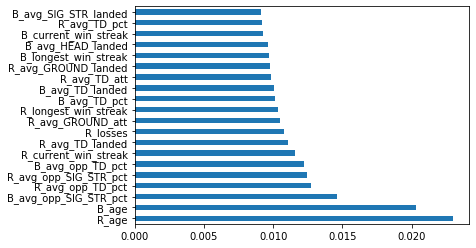

In [12]:
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

Correlation matrix
- Takes long time to generate, set true to do so.

In [0]:
doCorrelation = False
if doCorrelation:
  import seaborn as sns
  #get correlations of each features in dataset
  corrmat = df.corr()
  top_corr_features = corrmat.index
  plt.figure(figsize=(160,160))
  #plot heat map
  g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")


Confusion Matrix

In [14]:
def plot_cm(classifierName):
  from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
  from sklearn.utils.multiclass import unique_labels

  cm = confusion_matrix(y_test, results[classifierName]['predictions'])
  classes = unique_labels(y_test, results[classifierName]['predictions'])

  fig, ax = plt.subplots()
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  ax.figure.colorbar(im, ax=ax)

  ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes, yticklabels=classes,
        title='CM ' + classifierName,
        ylabel='True label',
        xlabel='Predicted label')

  fmt = 'd'
  thresh = cm.max() / 10
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="right",
                  color="gray" if cm[i, j] > thresh else "gray")
  fig.tight_layout()
  ax

allClassifiers = ['randomForest', 'extraTrees','supportVector', 'xgboost', 'multiLayerPerceptron']

for classifier in allClassifiers:
  plot_cm(classifier)

KeyError: ignored

# **Graphs**



Accuracy between different classifiers

KeyError: ignored

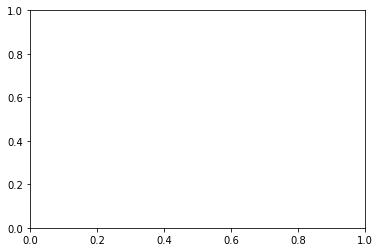

In [15]:
from matplotlib.ticker import FuncFormatter

def plot_accuracy_between_classifiers():
  allClassifierNames = ['RF', 'XT','SVM', 'XGB', 'MLP']
  fig, ax = plt.subplots()
  global results
  x = np.arange(5)
  accuracies = []

  for classifier in allClassifiers:
    accuracies.append(results[classifier]['accuracy'])

  plt.bar(x, accuracies)
  plt.xticks(x, (allClassifierNames[0],allClassifierNames[1],allClassifierNames[2],allClassifierNames[3], allClassifierNames[4]))
  ax.set_ylim(0.50, 0.62)
  plt.show()

plot_accuracy_between_classifiers()


# **Get updated data from fighter**
- In order to simulate a fight we need to get the fighters' latest stats and create a row similar to the training data. 

In [0]:
def getFight(name):
  fighter_R_rows = ['date','R_current_lose_streak',
 'R_current_win_streak' ,'R_draw' ,'R_avg_BODY_att' ,'R_avg_BODY_landed',
 'R_avg_CLINCH_att' ,'R_avg_CLINCH_landed' ,'R_avg_DISTANCE_att',
 'R_avg_DISTANCE_landed' ,'R_avg_GROUND_att' ,'R_avg_GROUND_landed',
 'R_avg_HEAD_att' ,'R_avg_HEAD_landed' ,'R_avg_KD' ,'R_avg_LEG_att',
 'R_avg_LEG_landed' ,'R_avg_PASS' ,'R_avg_REV' ,'R_avg_SIG_STR_att',
 'R_avg_SIG_STR_landed' ,'R_avg_SIG_STR_pct' ,'R_avg_SUB_ATT' ,'R_avg_TD_att',
 'R_avg_TD_landed' ,'R_avg_TD_pct' ,'R_avg_TOTAL_STR_att',
 'R_avg_TOTAL_STR_landed' ,'R_longest_win_streak' ,'R_losses',
 'R_avg_opp_BODY_att' ,'R_avg_opp_BODY_landed' ,'R_avg_opp_CLINCH_att',
 'R_avg_opp_CLINCH_landed' ,'R_avg_opp_DISTANCE_att',
 'R_avg_opp_DISTANCE_landed' ,'R_avg_opp_GROUND_att',
 'R_avg_opp_GROUND_landed' ,'R_avg_opp_HEAD_att' ,'R_avg_opp_HEAD_landed',
 'R_avg_opp_KD' ,'R_avg_opp_LEG_att' ,'R_avg_opp_LEG_landed',
 'R_avg_opp_PASS' ,'R_avg_opp_REV' ,'R_avg_opp_SIG_STR_att',
 'R_avg_opp_SIG_STR_landed' ,'R_avg_opp_SIG_STR_pct' ,'R_avg_opp_SUB_ATT',
 'R_avg_opp_TD_att' ,'R_avg_opp_TD_landed' ,'R_avg_opp_TD_pct',
 'R_avg_opp_TOTAL_STR_att' ,'R_avg_opp_TOTAL_STR_landed',
 'R_total_rounds_fought' ,'R_total_time_fought(seconds)',
 'R_total_title_bouts' ,'R_win_by_Decision_Majority',
 'R_win_by_Decision_Split' ,'R_win_by_Decision_Unanimous' ,'R_win_by_KO/TKO',
 'R_win_by_Submission' ,'R_win_by_TKO_Doctor_Stoppage' ,'R_wins',
 'R_Height_cms' ,'R_Reach_cms' ,'R_Weight_lbs', 'R_age', 'R_Stance','weight_class']


  fighter_B_rows = ['date','B_current_lose_streak',
  'B_current_win_streak' ,'B_draw' ,'B_avg_BODY_att' ,'B_avg_BODY_landed',
  'B_avg_CLINCH_att' ,'B_avg_CLINCH_landed' ,'B_avg_DISTANCE_att',
  'B_avg_DISTANCE_landed' ,'B_avg_GROUND_att' ,'B_avg_GROUND_landed',
  'B_avg_HEAD_att' ,'B_avg_HEAD_landed' ,'B_avg_KD' ,'B_avg_LEG_att',
  'B_avg_LEG_landed' ,'B_avg_PASS' ,'B_avg_REV' ,'B_avg_SIG_STR_att',
  'B_avg_SIG_STR_landed' ,'B_avg_SIG_STR_pct' ,'B_avg_SUB_ATT' ,'B_avg_TD_att',
  'B_avg_TD_landed' ,'B_avg_TD_pct' ,'B_avg_TOTAL_STR_att',
  'B_avg_TOTAL_STR_landed' ,'B_longest_win_streak' ,'B_losses',
  'B_avg_opp_BODY_att' ,'B_avg_opp_BODY_landed' ,'B_avg_opp_CLINCH_att',
  'B_avg_opp_CLINCH_landed' ,'B_avg_opp_DISTANCE_att',
  'B_avg_opp_DISTANCE_landed' ,'B_avg_opp_GROUND_att',
  'B_avg_opp_GROUND_landed' ,'B_avg_opp_HEAD_att' ,'B_avg_opp_HEAD_landed',
  'B_avg_opp_KD' ,'B_avg_opp_LEG_att' ,'B_avg_opp_LEG_landed',
  'B_avg_opp_PASS' ,'B_avg_opp_REV' ,'B_avg_opp_SIG_STR_att',
  'B_avg_opp_SIG_STR_landed' ,'B_avg_opp_SIG_STR_pct' ,'B_avg_opp_SUB_ATT',
  'B_avg_opp_TD_att' ,'B_avg_opp_TD_landed' ,'B_avg_opp_TD_pct',
  'B_avg_opp_TOTAL_STR_att' ,'B_avg_opp_TOTAL_STR_landed',
  'B_total_rounds_fought' ,'B_total_time_fought(seconds)',
  'B_total_title_bouts' ,'B_win_by_Decision_Majority',
  'B_win_by_Decision_Split' ,'B_win_by_Decision_Unanimous' ,'B_win_by_KO/TKO',
  'B_win_by_Submission' ,'B_win_by_TKO_Doctor_Stoppage' ,'B_wins',
  'B_Height_cms' ,'B_Reach_cms' ,'B_Weight_lbs','B_age', 'B_Stance', 'weight_class']
  fD = pd.read_csv('https://raw.githubusercontent.com/nystuen/UFC_Fight_Prediction/master/data2.csv')
  hasRedFight = False
  hasBlueFight = False

  try:
    latest_red_fight_fighter_B = fD.loc[fD['R_fighter'] == name][fighter_R_rows].iloc[0]
    hasRedFight = True
  except:
    print('could not find fight in fred corner for fighter:', name)

  try:
    latest_blue_fight_fighter_B = fD.loc[fD['B_fighter'] == name][fighter_B_rows].iloc[0]
    hasBlueFight = True
  except:
    print('could not find fight in blue corner for fighter:', name)  



  if hasRedFight and hasBlueFight :
     if latest_blue_fight_fighter_B.date > latest_red_fight_fighter_B.date:
       return latest_blue_fight_fighter_B
     else:
       return latest_red_fight_fighter_B
  elif hasRedFight:
    return latest_red_fight_fighter_B
  elif hasBlueFight:
    return latest_blue_fight_fighter_B
  else:
    raise Exception("Sorry, could not find a previous fight for this fighter")


In [0]:
def defineColumns():
  firstTwoColums = ['title_bout' ,'no_of_rounds']

  blueColumns = ['B_current_lose_streak',
  'B_current_win_streak' ,'B_draw' ,'B_avg_BODY_att' ,'B_avg_BODY_landed',
  'B_avg_CLINCH_att' ,'B_avg_CLINCH_landed' ,'B_avg_DISTANCE_att',
  'B_avg_DISTANCE_landed' ,'B_avg_GROUND_att' ,'B_avg_GROUND_landed',
  'B_avg_HEAD_att' ,'B_avg_HEAD_landed' ,'B_avg_KD' ,'B_avg_LEG_att',
  'B_avg_LEG_landed' ,'B_avg_PASS' ,'B_avg_REV' ,'B_avg_SIG_STR_att',
  'B_avg_SIG_STR_landed' ,'B_avg_SIG_STR_pct' ,'B_avg_SUB_ATT' ,'B_avg_TD_att',
  'B_avg_TD_landed' ,'B_avg_TD_pct' ,'B_avg_TOTAL_STR_att',
  'B_avg_TOTAL_STR_landed' ,'B_longest_win_streak' ,'B_losses',
  'B_avg_opp_BODY_att' ,'B_avg_opp_BODY_landed' ,'B_avg_opp_CLINCH_att',
  'B_avg_opp_CLINCH_landed' ,'B_avg_opp_DISTANCE_att',
  'B_avg_opp_DISTANCE_landed' ,'B_avg_opp_GROUND_att',
  'B_avg_opp_GROUND_landed' ,'B_avg_opp_HEAD_att' ,'B_avg_opp_HEAD_landed',
  'B_avg_opp_KD' ,'B_avg_opp_LEG_att' ,'B_avg_opp_LEG_landed',
  'B_avg_opp_PASS' ,'B_avg_opp_REV' ,'B_avg_opp_SIG_STR_att',
  'B_avg_opp_SIG_STR_landed' ,'B_avg_opp_SIG_STR_pct' ,'B_avg_opp_SUB_ATT',
  'B_avg_opp_TD_att' ,'B_avg_opp_TD_landed' ,'B_avg_opp_TD_pct',
  'B_avg_opp_TOTAL_STR_att' ,'B_avg_opp_TOTAL_STR_landed',
  'B_total_rounds_fought' ,'B_total_time_fought(seconds)',
  'B_total_title_bouts' ,'B_win_by_Decision_Majority',
  'B_win_by_Decision_Split' ,'B_win_by_Decision_Unanimous' ,'B_win_by_KO/TKO',
  'B_win_by_Submission' ,'B_win_by_TKO_Doctor_Stoppage' ,'B_wins',
  'B_Height_cms' ,'B_Reach_cms' ,'B_Weight_lbs','B_age', 'B_Stance_Open Stance' ,'B_Stance_Orthodox' ,
 'B_Stance_Southpaw']

  redColumns = ['R_current_lose_streak',
 'R_current_win_streak' ,'R_draw' ,'R_avg_BODY_att' ,'R_avg_BODY_landed',
 'R_avg_CLINCH_att' ,'R_avg_CLINCH_landed' ,'R_avg_DISTANCE_att',
 'R_avg_DISTANCE_landed' ,'R_avg_GROUND_att' ,'R_avg_GROUND_landed',
 'R_avg_HEAD_att' ,'R_avg_HEAD_landed' ,'R_avg_KD' ,'R_avg_LEG_att',
 'R_avg_LEG_landed' ,'R_avg_PASS' ,'R_avg_REV' ,'R_avg_SIG_STR_att',
 'R_avg_SIG_STR_landed' ,'R_avg_SIG_STR_pct' ,'R_avg_SUB_ATT' ,'R_avg_TD_att',
 'R_avg_TD_landed' ,'R_avg_TD_pct' ,'R_avg_TOTAL_STR_att',
 'R_avg_TOTAL_STR_landed' ,'R_longest_win_streak' ,'R_losses',
 'R_avg_opp_BODY_att' ,'R_avg_opp_BODY_landed' ,'R_avg_opp_CLINCH_att',
 'R_avg_opp_CLINCH_landed' ,'R_avg_opp_DISTANCE_att',
 'R_avg_opp_DISTANCE_landed' ,'R_avg_opp_GROUND_att',
 'R_avg_opp_GROUND_landed' ,'R_avg_opp_HEAD_att' ,'R_avg_opp_HEAD_landed',
 'R_avg_opp_KD' ,'R_avg_opp_LEG_att' ,'R_avg_opp_LEG_landed',
 'R_avg_opp_PASS' ,'R_avg_opp_REV' ,'R_avg_opp_SIG_STR_att',
 'R_avg_opp_SIG_STR_landed' ,'R_avg_opp_SIG_STR_pct' ,'R_avg_opp_SUB_ATT',
 'R_avg_opp_TD_att' ,'R_avg_opp_TD_landed' ,'R_avg_opp_TD_pct',
 'R_avg_opp_TOTAL_STR_att' ,'R_avg_opp_TOTAL_STR_landed',
 'R_total_rounds_fought' ,'R_total_time_fought(seconds)',
 'R_total_title_bouts' ,'R_win_by_Decision_Majority',
 'R_win_by_Decision_Split' ,'R_win_by_Decision_Unanimous' ,'R_win_by_KO/TKO',
 'R_win_by_Submission' ,'R_win_by_TKO_Doctor_Stoppage' ,'R_wins',
 'R_Height_cms' ,'R_Reach_cms' ,'R_Weight_lbs','R_Stance_Open Stance',
 'R_Stance_Orthodox' ,'R_Stance_Southpaw']


  all_rows = ['title_bout' ,'no_of_rounds' ,'B_current_lose_streak',
 'B_current_win_streak' ,'B_draw' ,'B_avg_BODY_att' ,'B_avg_BODY_landed',
 'B_avg_CLINCH_att' ,'B_avg_CLINCH_landed' ,'B_avg_DISTANCE_att',
 'B_avg_DISTANCE_landed' ,'B_avg_GROUND_att' ,'B_avg_GROUND_landed',
 'B_avg_HEAD_att' ,'B_avg_HEAD_landed' ,'B_avg_KD' ,'B_avg_LEG_att',
 'B_avg_LEG_landed' ,'B_avg_PASS' ,'B_avg_REV' ,'B_avg_SIG_STR_att',
 'B_avg_SIG_STR_landed' ,'B_avg_SIG_STR_pct' ,'B_avg_SUB_ATT' ,'B_avg_TD_att',
 'B_avg_TD_landed' ,'B_avg_TD_pct' ,'B_avg_TOTAL_STR_att',
 'B_avg_TOTAL_STR_landed' ,'B_longest_win_streak' ,'B_losses',
 'B_avg_opp_BODY_att' ,'B_avg_opp_BODY_landed' ,'B_avg_opp_CLINCH_att',
 'B_avg_opp_CLINCH_landed' ,'B_avg_opp_DISTANCE_att',
 'B_avg_opp_DISTANCE_landed' ,'B_avg_opp_GROUND_att',
 'B_avg_opp_GROUND_landed' ,'B_avg_opp_HEAD_att' ,'B_avg_opp_HEAD_landed',
 'B_avg_opp_KD' ,'B_avg_opp_LEG_att' ,'B_avg_opp_LEG_landed',
 'B_avg_opp_PASS' ,'B_avg_opp_REV' ,'B_avg_opp_SIG_STR_att',
 'B_avg_opp_SIG_STR_landed' ,'B_avg_opp_SIG_STR_pct' ,'B_avg_opp_SUB_ATT',
 'B_avg_opp_TD_att' ,'B_avg_opp_TD_landed' ,'B_avg_opp_TD_pct',
 'B_avg_opp_TOTAL_STR_att' ,'B_avg_opp_TOTAL_STR_landed',
 'B_total_rounds_fought' ,'B_total_time_fought(seconds)',
 'B_total_title_bouts' ,'B_win_by_Decision_Majority',
 'B_win_by_Decision_Split' ,'B_win_by_Decision_Unanimous' ,'B_win_by_KO/TKO',
 'B_win_by_Submission' ,'B_win_by_TKO_Doctor_Stoppage' ,'B_wins',
 'B_Height_cms' ,'B_Reach_cms' ,'B_Weight_lbs' ,'R_current_lose_streak',
 'R_current_win_streak' ,'R_draw' ,'R_avg_BODY_att' ,'R_avg_BODY_landed',
 'R_avg_CLINCH_att' ,'R_avg_CLINCH_landed' ,'R_avg_DISTANCE_att',
 'R_avg_DISTANCE_landed' ,'R_avg_GROUND_att' ,'R_avg_GROUND_landed',
 'R_avg_HEAD_att' ,'R_avg_HEAD_landed' ,'R_avg_KD' ,'R_avg_LEG_att',
 'R_avg_LEG_landed' ,'R_avg_PASS' ,'R_avg_REV' ,'R_avg_SIG_STR_att',
 'R_avg_SIG_STR_landed' ,'R_avg_SIG_STR_pct' ,'R_avg_SUB_ATT' ,'R_avg_TD_att',
 'R_avg_TD_landed' ,'R_avg_TD_pct' ,'R_avg_TOTAL_STR_att',
 'R_avg_TOTAL_STR_landed' ,'R_longest_win_streak' ,'R_losses',
 'R_avg_opp_BODY_att' ,'R_avg_opp_BODY_landed' ,'R_avg_opp_CLINCH_att',
 'R_avg_opp_CLINCH_landed' ,'R_avg_opp_DISTANCE_att',
 'R_avg_opp_DISTANCE_landed' ,'R_avg_opp_GROUND_att',
 'R_avg_opp_GROUND_landed' ,'R_avg_opp_HEAD_att' ,'R_avg_opp_HEAD_landed',
 'R_avg_opp_KD' ,'R_avg_opp_LEG_att' ,'R_avg_opp_LEG_landed',
 'R_avg_opp_PASS' ,'R_avg_opp_REV' ,'R_avg_opp_SIG_STR_att',
 'R_avg_opp_SIG_STR_landed' ,'R_avg_opp_SIG_STR_pct' ,'R_avg_opp_SUB_ATT',
 'R_avg_opp_TD_att' ,'R_avg_opp_TD_landed' ,'R_avg_opp_TD_pct',
 'R_avg_opp_TOTAL_STR_att' ,'R_avg_opp_TOTAL_STR_landed',
 'R_total_rounds_fought' ,'R_total_time_fought(seconds)',
 'R_total_title_bouts' ,'R_win_by_Decision_Majority',
 'R_win_by_Decision_Split' ,'R_win_by_Decision_Unanimous' ,'R_win_by_KO/TKO',
 'R_win_by_Submission' ,'R_win_by_TKO_Doctor_Stoppage' ,'R_wins',
 'R_Height_cms' ,'R_Reach_cms' ,'R_Weight_lbs' ,'B_age' ,'R_age',
 'weight_class_Bantamweight' ,'weight_class_Catch Weight',
 'weight_class_Featherweight' ,'weight_class_Flyweight',
 'weight_class_Heavyweight' ,'weight_class_Light Heavyweight',
 'weight_class_Lightweight' ,'weight_class_Middleweight',
 'weight_class_Open Weight' ,'weight_class_Welterweight',
 'weight_class_Womens_Bantamweight' ,'weight_class_Womens_Featherweight',
 'weight_class_Womens_Flyweight' ,'weight_class_Womens_Strawweight',
  'B_Stance_Open Stance', 'B_Stance_Orthodox', 'B_Stance_Southpaw',
 'B_Stance_Switch', 'R_Stance_Open Stance', 'R_Stance_Orthodox',
 'R_Stance_Southpaw', 'R_Stance_Switch']

  weightClassColumns = ['weight_class_Bantamweight', 'weight_class_Catch Weight',
 'weight_class_Featherweight' ,'weight_class_Flyweight',
 'weight_class_Heavyweight' ,'weight_class_Light Heavyweight',
 'weight_class_Lightweight' ,'weight_class_Middleweight',
 'weight_class_Open Weight' ,'weight_class_Welterweight',
 'weight_class_Womens_Bantamweight' ,'weight_class_Womens_Featherweight',
 'weight_class_Womens_Flyweight' ,'weight_class_Womens_Strawweight']

  return firstTwoColums, blueColumns, redColumns, all_rows, weightClassColumns

firstTwoColumns, blueColumns, redColumns, all_rows, weightClassColumns = defineColumns()

def csvDf(dat,**kwargs): 
  from numpy import array
  data = array(dat)
  if data is None or len(data)==0 or len(data[0])==0:
    return None
  else:
    return pd.DataFrame(data[1:,1:],index=data[1:,0],columns=data[0,1:],**kwargs)


def getFightersOriginalColor(fighter_R):
      try:
        if(fighter_R.R_age):
          return 'R'
      except:
        return 'B'   

def getStanceArray(stance, color):
  stance = stance.lower()
  stanceBlueArray = [0, 0, 0, 0];
  stanceRedArray = [0, 0, 0, 0]
  isRed = color == 'R'
 
  if stance == 'open stance':
    if isRed:
      stanceRedArray[0] = 1
    else:
      stanceBlueArray[0] = 1

  elif stance == 'orthodox':
    if isRed:
      stanceRedArray[1] = 1
    else:
      stanceBlueArray[1] = 1
  elif stance == 'sideways':
      stanceBlueArray[2] = 1
  elif stance == 'southpaw':
    if isRed:
      stanceRedArray[2] = 1
    else:
      stanceBlueArray[2] = 1
  elif stance == 'switch':
    if isRed:
      stanceRedArray[3] = 1
    else:
      stanceBlueArray[3] = 1
  

  if isRed:
    return stanceRedArray
  else:
    return stanceBlueArray


def getIndexOfStringInArray(array, string):
  for i in range(len(array)):
    if(array[i].lower() == string.lower()):
      return i
  return -1


def getWeightClassArray(weightClass):

  weightClasses = ['Bantamweight', 'Catch Weight',
                 'Featherweight', 'Flyweight',
                 'Heavyweight', 'Light Heavyweight',
                 'Lightweight', 'Middleweight',
                 'Open Weight', 'Welterweight',
                 'Womens Bantamweight', 'Womens Featherweight',
                 'Womens Flyweight', 'Womens Strawweight']

  weightClassArray = np.zeros(len(weightClasses))
  index = getIndexOfStringInArray(weightClasses, weightClass)
  weightClassArray[index] = 1
  return weightClassArray



def getDataFrame(fighter_R_name, fighter_B_name):

  global all_rows
  fighter_1_data = getFight(fighter_R_name)
  fighter_2_data = getFight(fighter_B_name)

  final_rows = []
  first_two_rows = []
  ages = []
  fighter_1_stance_array = []
  fighter_2_stance_array = []
  weight_class_array = []


  # Which color is fighter 1 and fighter 2 originally in the dataset?
  fighter_1_color_original = getFightersOriginalColor(fighter_1_data)
  fighter_2_color_original = getFightersOriginalColor(fighter_2_data)


  # Which color is fighter 1 and fighter two in this fight?
  fighter_1_color = 'R'
  fighter_2_color = 'B'


  # Prepare first two columns in data
  title_bout = 0
  no_of_rounds = 3
  first_two_rows.append(title_bout)
  first_two_rows.append(no_of_rounds)
  

  # Retrieve ages of both fighters, b_age is first then r_age
  if(fighter_2_color_original == 'R'):
    ages.append(fighter_2_data.R_age)
  else:
    ages.append(fighter_2_data.B_age)

  if(fighter_1_color_original == 'R'):
    ages.append(fighter_1_data.R_age)
  else:
    ages.append(fighter_1_data.B_age)


  # Retrieve stancearrays for both fighters, B is first
  if(fighter_2_color_original == 'R'):
    fighter_2_stance_array = getStanceArray(fighter_2_data.R_Stance, fighter_2_color)
  else:  
    fighter_2_stance_array = getStanceArray(fighter_2_data.B_Stance, fighter_2_color)

  if(fighter_1_color_original == 'R'):
    fighter_1_stance_array = getStanceArray(fighter_1_data.R_Stance,fighter_1_color)
  else:  
    fighter_1_stance_array = getStanceArray(fighter_1_data.B_Stance,fighter_1_color)


  # Retrieve which weightclass we are in
  weight_class_array = getWeightClassArray(fighter_1_data.weight_class)
  fighter_R = getFight(fighter_R_name)

  # Make one huge row of all arrays
  # first we need to two three last columns from fighter 1 and 2 data

  fighter_1_data = fighter_1_data.drop("weight_class")
  fighter_2_data = fighter_2_data.drop("weight_class")
  fighter_1_data = fighter_1_data.drop("date")
  fighter_2_data = fighter_2_data.drop("date")
  if fighter_1_color_original == 'R':
    fighter_1_data = fighter_1_data.drop("R_Stance")
    fighter_1_data = fighter_1_data.drop("R_age")
  else:
    fighter_1_data = fighter_1_data.drop("B_Stance")
    fighter_1_data = fighter_1_data.drop("B_age")

  if fighter_2_color_original == 'R':
    fighter_2_data = fighter_2_data.drop("R_Stance")
    fighter_2_data = fighter_2_data.drop("R_age")
  else:
    fighter_2_data = fighter_2_data.drop("B_Stance")
    fighter_2_data = fighter_2_data.drop("B_age")

 
  weight_class_array = list(map(int, weight_class_array))
  
  final_rows = first_two_rows + list(fighter_1_data) + list(fighter_2_data)+ ages + weight_class_array + fighter_2_stance_array + fighter_1_stance_array
  return final_rows


# **Defining functions for probability of win both normally and independently of corner color**

In [0]:
def getFightPredictionProbability(fighter_A, fighter_B):
  
  # Run prediction 
  df = getDataFrame(fighter_A, fighter_B)
  data = [[' '] + all_rows, [' '] + df]
  df = pd.DataFrame(csvDf(data))
  [prob_A,prob_B] = model.predict_proba(df)[0]
  
  if prob_A > prob_B:
    return (fighter_A, prob_A)
  elif prob_A < prob_B:
    return (fighter_B, prob_B)
  else:
    return ('Tie', 0.5)  

def getFightPredictionProbablityIndependentlyOfCorner(fighter_A, fighter_B):

  # Run prediction 
  df = getDataFrame(fighter_A, fighter_B)
  data = [[' '] + all_rows, [' '] + df]
  df = pd.DataFrame(csvDf(data))
  [blue_prob_A,red_prob_B] = model.predict_proba(df)[0]

  ## Run prediction again with switches corners
  df = getDataFrame(fighter_B, fighter_A)
  data = [[' '] + all_rows, [' '] + df]
  df = pd.DataFrame(csvDf(data))
  [blue_prob_B,red_prob_A] = model.predict_proba(df)[0]

  #print('red_prob_A',red_prob_A)
  #print('blue_prob_A',blue_prob_A)
  #print('red_prob_B',red_prob_B )
  #print('blue_prob_B',blue_prob_B)

  prob_A = (red_prob_A + blue_prob_A)/2
  prob_B = (red_prob_B + blue_prob_B)/2

  if prob_A > prob_B:
    return (fighter_A, prob_A)
  elif prob_A < prob_B:
    return (fighter_B, prob_B)
  else:
    return ('Tie', 0.5)  

# **UFC Fight Predictor**


In [0]:
def pred():
  print(' Name of fighter A')
  fighter_A = input()
  print(' Name of fighter B')
  fighter_B = input()

  print('Predicting....')
  (winner, prob) = getFightPredictionProbability(fighter_A,fighter_B)

  print("The winner will be " + winner)

pred()